## Import libraries

In [1]:
import os 

CUDA=0

NAME = '1103_tf_ver6_1000fold'
OUTPUT_DIR = f'./results/{NAME}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
DATA_DIR = '../input/ventilator-pressure-prediction/'

In [2]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Dense, Dropout, Input, Activation
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

np.random.seed(42)
tf.random.set_seed(42)

## Load source datasets

In [3]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [5]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"})\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

del train_df
del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


0

In [6]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 64) 
test: (4024000, 64)


In [7]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 64) 
test: (50300, 80, 64) 
targets: (75450, 80)


In [8]:
pressure = targets.squeeze().reshape(-1,1).astype('float32')

P_MIN = np.min(pressure)
P_MAX = np.max(pressure)
P_STEP = (pressure[1] - pressure[0])[0]
print('Min pressure: {}'.format(P_MIN))
print('Max pressure: {}'.format(P_MAX))
print('Pressure step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(pressure).shape[0]))

del pressure
gc.collect()

Min pressure: -1.8957443237304688
Max pressure: 64.82099151611328
Pressure step: 0.07030248641967773
Unique values:  950


69

## Hardware config

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


## Keras DNN Model

In [10]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    # x_emb = Dense(units=1024)(x_input)
    # x_emb = LayerNormalization()(x_emb)
    # x_emb = Activation('selu')(x_emb)
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(Concatenate(axis=2)([x2, x3]))
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(LSTM(units=256, return_sequences=True))(Concatenate(axis=2)([x2, z31]))
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(LSTM(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(LSTM(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [11]:
with tf.device(f'/device:GPU:{CUDA}'):
    model = dnn_model()
    model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 64)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5117952     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 768)      4328448     bidirectional_1[0][0]            
__________________________________________________________________________________________

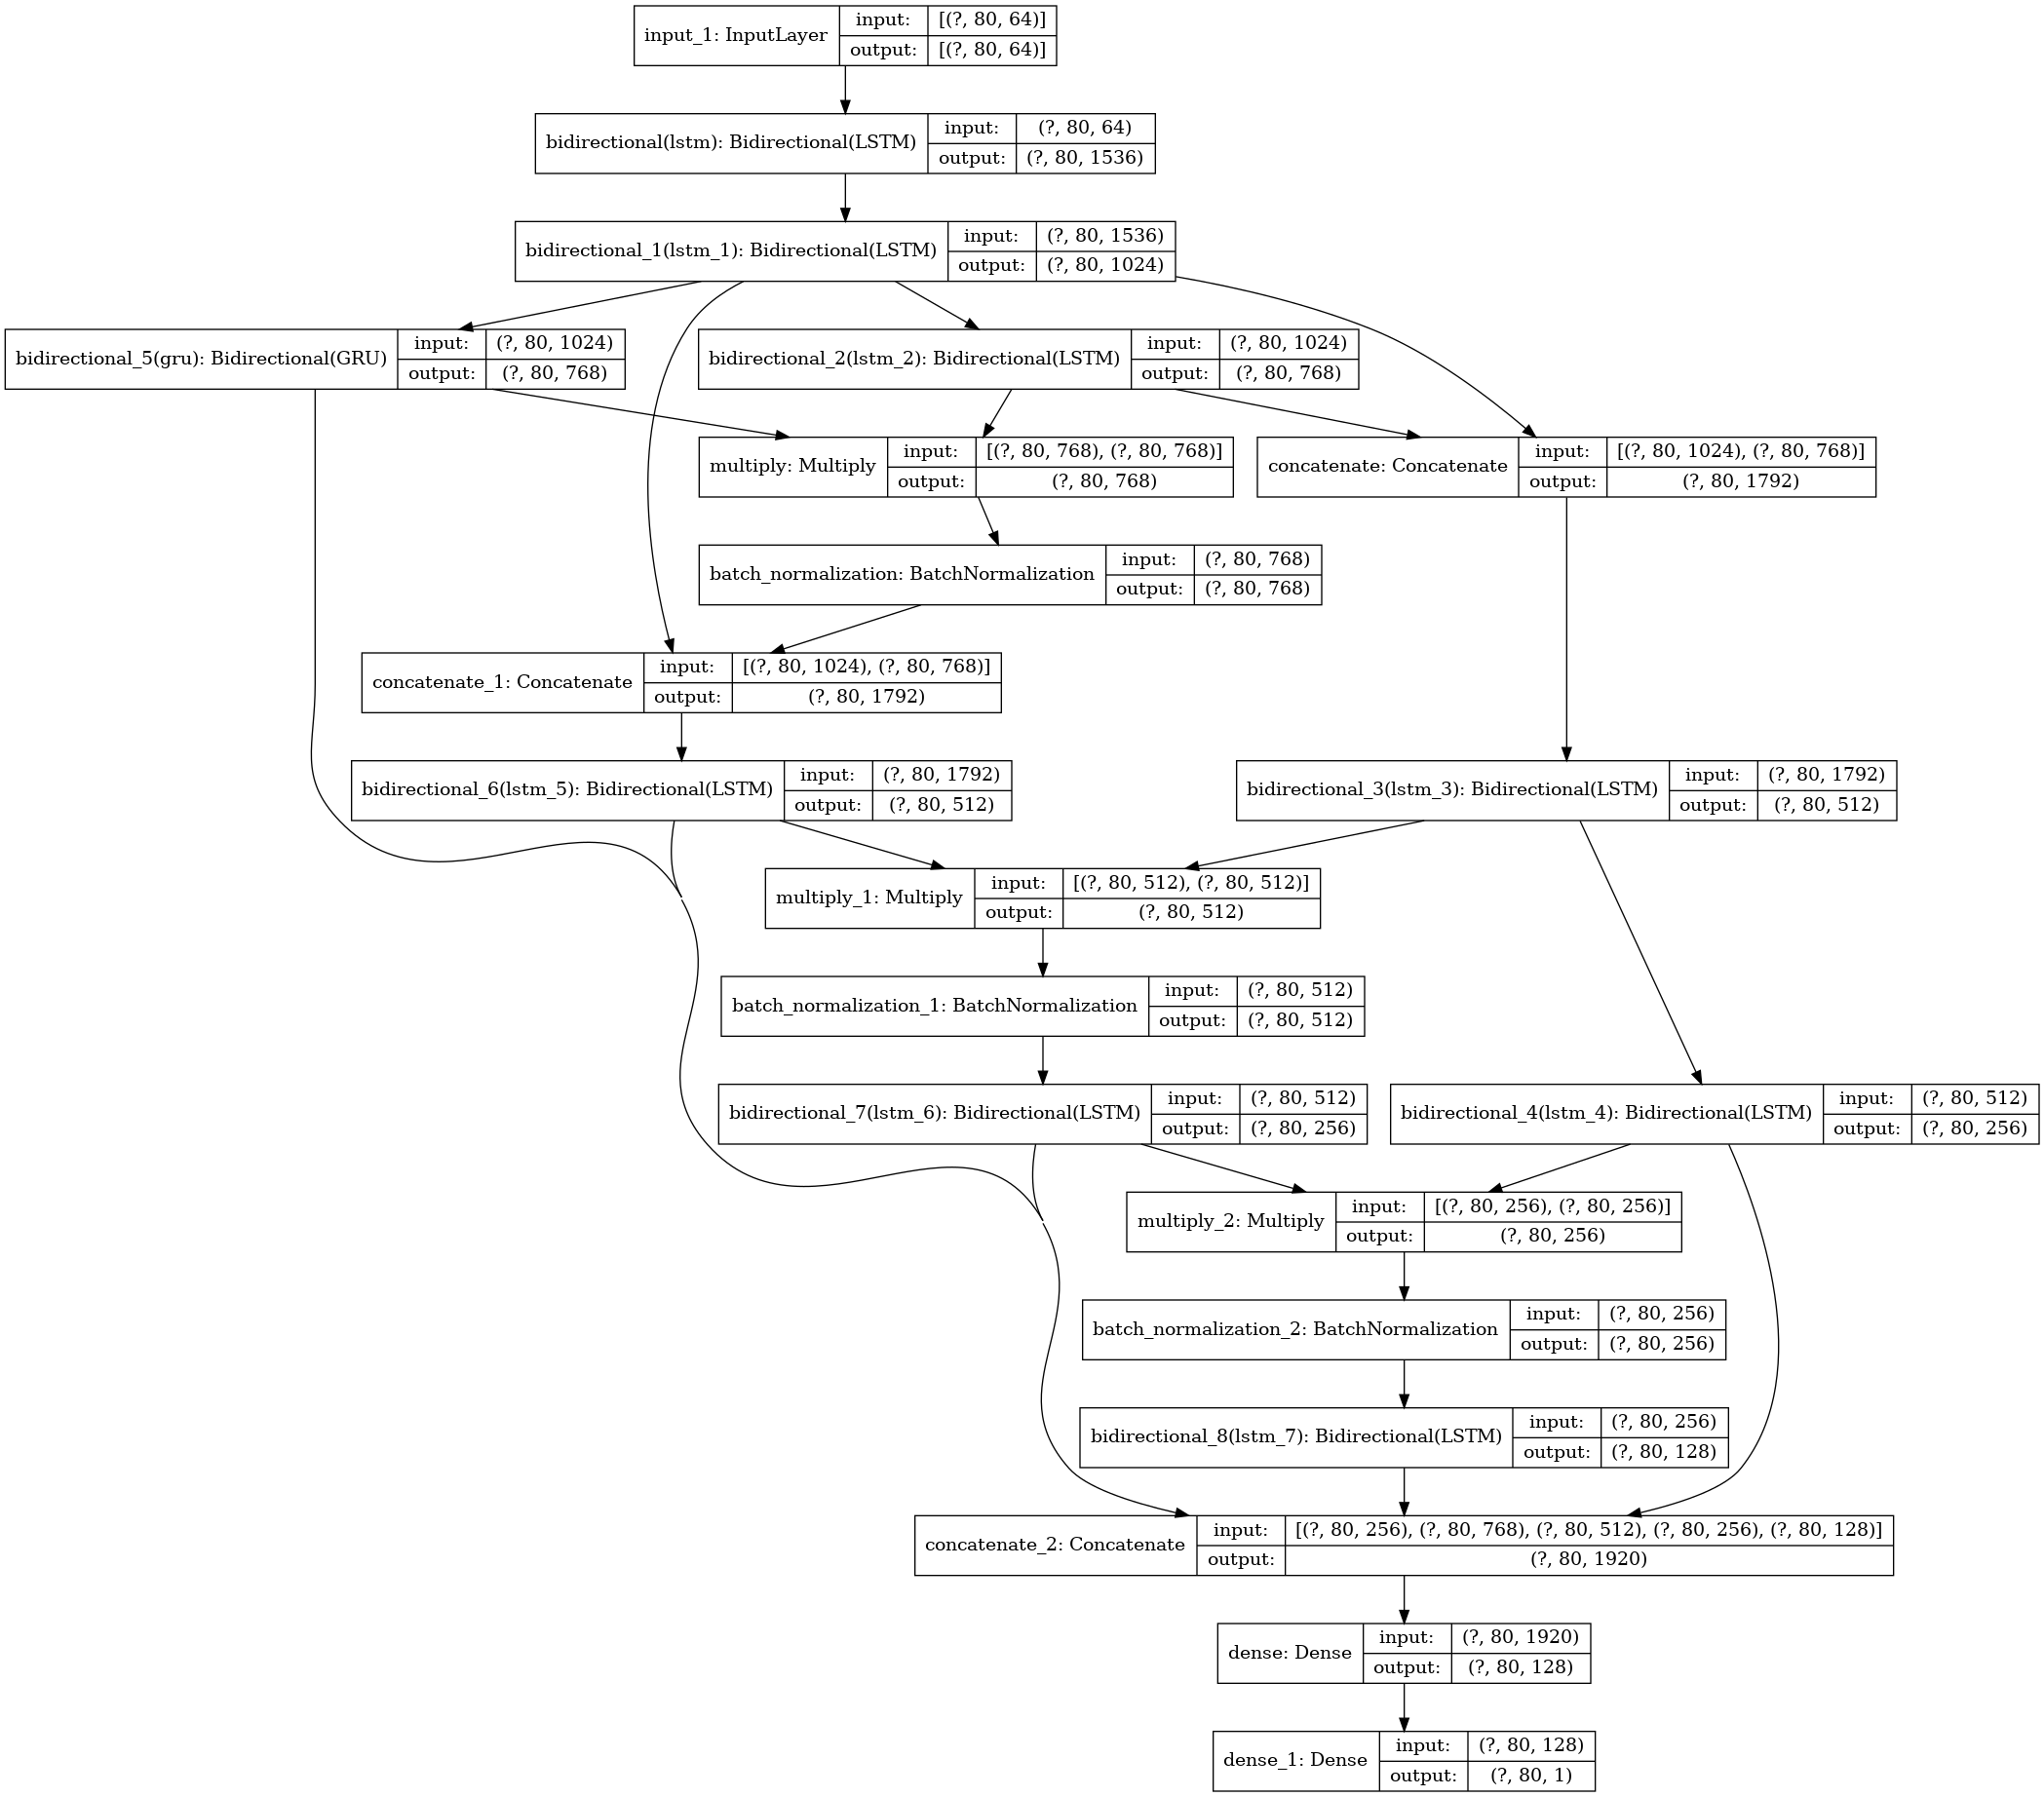

In [12]:
plot_model(
    model, 
    to_file=OUTPUT_DIR+'Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
import wandb
from wandb.keras import WandbCallback




with tf.device(f'/device:GPU:{CUDA}'):
    VERBOSE = 1
    test_preds = []
    kf = KFold(n_splits=1000, shuffle=True, random_state=2021)

    all_score = 0
    count = 0
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        run = wandb.init(project="Ventilator-Pressure-Public-tf", 
                     name=f'fold_{fold}',
                     config={"hyper": "parameter"},
                     group=NAME,
                    job_type='train')
        
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]

        model = dnn_model()

        #scheduler = CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=20, t_mul=1, alpha=1e-5)
        #optimizer = Adam(learning_rate=scheduler)

        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.85, 
                               patience=10, verbose=VERBOSE)

        # save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(OUTPUT_DIR+f'./Bidirect_LSTM_model_2021_{fold+1}C.h5', #options=save_locally, 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=30, 
                           verbose=VERBOSE, mode="min", 
                           restore_best_weights=True)

        model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=300,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr, chk_point, es, WandbCallback()])

        # load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(OUTPUT_DIR+f'./Bidirect_LSTM_model_2021_{fold+1}C.h5') #options=load_locally

        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        count += 1
        all_score += score

        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())
        
        run.finish()
        
        if fold==4:
            break
        
    print(f'CV Score: {all_score/count:<.4f}')

wandb: Currently logged in as: hypknot (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/300
148/148 [==============================] - ETA: 0s - loss: 1.3144
Epoch 00001: val_loss improved from inf to 1.71863, saving model to ./results/1103_tf_ver6_1000fold/./Bidirect_LSTM_model_2021_1C.h5
148/148 [==============================] - 35s 237ms/step - loss: 1.3144 - val_loss: 1.7186
Epoch 2/300
148/148 [==============================] - ETA: 0s - loss: 0.5818
Epoch 00002: val_loss improved from 1.71863 to 1.21430, saving model to ./results/1103_tf_ver6_1000fold/./Bidirect_LSTM_model_2021_1C.h5
148/148 [==============================] - 32s 215ms/step - loss: 0.5818 - val_loss: 1.2143
Epoch 3/300
148/148 [==============================] - ETA: 0s - loss: 0.4856
Epoch 00003: val_loss improved from 1.21430 to 0.56349, saving model to ./results/1103_tf_ver6_1000fold/./Bidirect_LSTM_model_2021_1C.h5
148/148 [==============================] - 32s 218ms/step - loss: 0.4856 - val_loss: 0.5635
Epoch 4/300
148/148 [==============================] - ETA: 0s - loss: 0.4451
Epoch

## Create submission file

In [ ]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

unique_pressures = train["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

def find_nearest(prediction):
    '''
    予測値は離散値であるため、学習データにある最も近い離散値に置き換える
    '''
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

In [ ]:
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/5
submission.to_csv(OUTPUT_DIR+'mean_submission.csv', index=False)

In [ ]:
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission["pressure"] = np.round((submission.pressure - P_MIN)/P_STEP) * P_STEP + P_MIN
submission["pressure"] = np.clip(submission.pressure, P_MIN, P_MAX)
submission["pressure"] = submission["pressure"].apply(find_nearest)
submission.to_csv(OUTPUT_DIR+'median_submission.csv', index=False)